# Random Walks and Diffusion

*20th November 2025* - **Credits:** Luca Ciandrini (luca.ciandrini@umontpellier.fr)

---
From the Feynamn's Lectures on Physics, Vol I Ch.6:
>... imagine a “game” in which a “player” starts at the point x=0 and at each “move” is required to take a step either forward (toward +x) or backward (toward −x). The choice is to be made randomly, determined, for example, by the toss of a coin. How shall we describe the resulting motion? In its general form the problem is related to the motion of atoms (or other particles) in a gas—called Brownian motion—and also to the combination of errors in measurements.

Let's try to implement that.

## Random Walks in 1D
For the sake of simplicity let's say that the displacements can be $a = \pm 1$. And let's see how the distance from the starting point evolves in time (and after $N = t/\Delta t$ total steps). Also, to start with, $k_l=k_r$.

# Random walks and diffusion in biology

In this notebook we will:

- Simulate a simple one-dimensional random walk.
- Look at individual trajectories.
- Compute the mean and mean-square displacement over many trajectories.
- See how the random walk connects to the diffusion law.
- Use the diffusion law to estimate timescales over biological distances.

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# This makes plots appear inside the notebook (uncomment if using classic notebooks)
# %matplotlib inline

## 1. A simple one-dimensional random walk with rates

We now define a slightly more realistic model.

- The particle sits on a 1D lattice (positions ..., -2, -1, 0, 1, 2, ...).
- Time is discretised in small intervals of length `Δt`.
- At each time step:
  - it can jump one site to the **left** with probability `rate_left * Δt`,
  - it can jump one site to the **right** with probability `rate_right * Δt`,
  - or it **stays where it is** with the remaining probability.

For a symmetric random walk we choose `rate_left = rate_right = rate`.

This description is equivalent to a continuous-time process with jump rates
(`rate_left`, `rate_right`), observed at discrete times separated by `Δt`.

In [36]:
from numpy.random import random

def step_1D_RW(rate_left, rate_right, delta_t):
    """
    Perform a single step of a 1D random walk with given rates.
    
    Parameters
    ----------
    rate_left : float
        Jump rate to the left (per unit time).
    rate_right : float
        Jump rate to the right (per unit time).
    delta_t : float
        Time step size.
        
    Returns
    -------
    step_x : int
        -1 if the walker jumps left,
         0 if it stays,
        +1 if it jumps right.
    """
    step_x = 0
    
    prob_left = rate_left * delta_t
    prob_right = rate_right * delta_t
    
    # Draw a random number between 0 and 1
    ran = random()
    
    if ran <= prob_left:
        # step to the left
        step_x = -1
    elif ran <= prob_left + prob_right:
        # step to the right
        step_x = +1
    else:
        # otherwise: stay put (step_x = 0)
        step_x = 0
    
    return step_x


def random_walk_1d(N_steps, rate_left, rate_right, delta_t, a=1.0):
    """
    Simulate a 1D random walk with jump rates and small time step Δt.
    
    Parameters
    ----------
    N_steps : int
        Number of time steps.
    rate_left : float
        Jump rate to the left (per unit time).
    rate_right : float
        Jump rate to the right (per unit time).
    delta_t : float
        Time step size.
    a : float
        Lattice spacing / step length.
        
    Returns
    -------
    x : numpy array of shape (N_steps+1,)
        Positions at each time step (starting from 0).
    t : numpy array of shape (N_steps+1,)
        Times corresponding to each step.
    """
    x = np.zeros(N_steps + 1)
    t = np.arange(N_steps + 1) * delta_t
    
    for n in range(N_steps):
        step = step_1D_RW(rate_left, rate_right, delta_t)
        x[n+1] = x[n] + a * step
    
    return x, t

### 1.1 A single trajectory

Let us generate one random walk with 1000 time steps and plot the position as a function of time.
In this model the particle can move left, right, or stay in place at each time step.

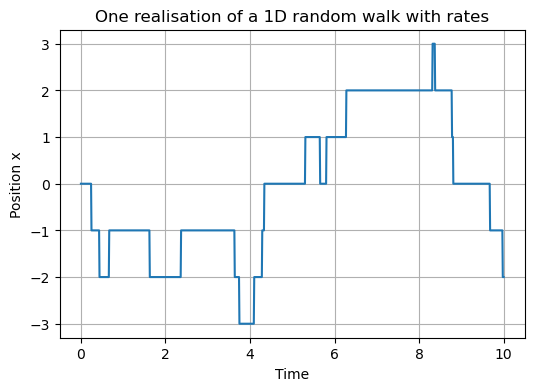

In [37]:
# Parameters for the random walk
N_steps   = 1000      # number of time steps
delta_t   = 0.01      # time step size (arbitrary units)
rate_left = 1.0       # rate to jump left  (per unit time)
rate_right= 1.0       # rate to jump right (per unit time)
a         = 1.0       # lattice spacing

# Simulate one trajectory
x_single, t_single = random_walk_1d(N_steps, rate_left, rate_right, delta_t, a=a)

# Plot
plt.figure(figsize=(6,4))
plt.plot(t_single, x_single)
plt.xlabel("Time")
plt.ylabel("Position x")
plt.title("One realisation of a 1D random walk with rates")
plt.grid(True)
plt.show()

In [40]:
def simulate_ensemble(N_walkers, N_steps, rate_left, rate_right, delta_t, a=1.0):
    """
    Simulate an ensemble of 1D random walks with given rates.
    
    Parameters
    ----------
    N_walkers : int
        Number of independent walkers.
    N_steps : int
        Number of time steps per walker.
    rate_left, rate_right : float
        Jump rates (per unit time).
    delta_t : float
        Time step size.
    a : float
        Lattice spacing.
        
    Returns
    -------
    X : numpy array of shape (N_walkers, N_steps+1)
        Positions of all walkers.
    t : numpy array of shape (N_steps+1,)
        Time points.
    """
    X = np.zeros((N_walkers, N_steps + 1))
    t = np.arange(N_steps + 1) * delta_t
    
    for i in range(N_walkers):
        x_i, _ = random_walk_1d(N_steps, rate_left, rate_right, delta_t, a=a)
        X[i, :] = x_i
    
    return X, t


# Parameters
N_walkers = 500
N_steps   = 1000
delta_t   = 0.01
rate_left = 1.0
rate_right= 1.0
a         = 1.0

# Simulate ensemble
X, t = simulate_ensemble(N_walkers, N_steps, rate_left, rate_right, delta_t, a=a)
X.shape

(500, 1001)

## 2. Many trajectories and mean-square displacement

A single trajectory is noisy and hard to analyse.
To see the underlying behaviour, we repeat the random walk many times and compute:

- the mean position ⟨x⟩ over all walkers,
- the mean-square displacement ⟨x²⟩ over all walkers.

We expect:
- ⟨x⟩ ≈ 0 (no drift),
- ⟨x²⟩ grows proportional to time (number of steps).

### 2.0 Visualising many trajectories

Before looking at the mean and the mean-square displacement, 
it is helpful to see the raw data: many random walk trajectories.

Each line below is one walker.  
The cloud of lines spreading out around zero is exactly what the MSD will quantify.

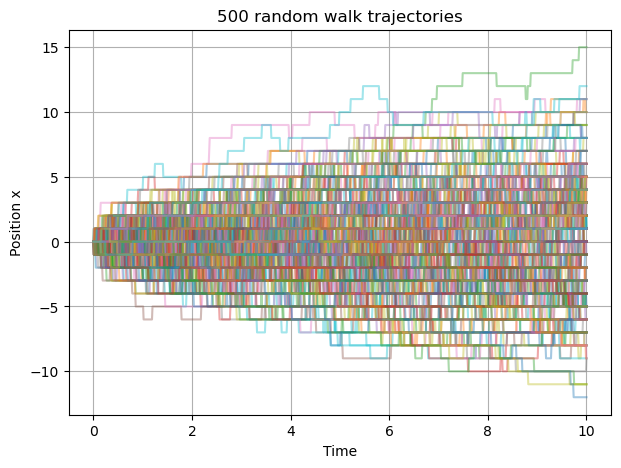

In [48]:
# Number of trajectories to display (to keep the plot readable)
N_show = 500

plt.figure(figsize=(7,5))

for i in range(N_show):
    plt.plot(t, X[i, :], alpha=0.4)

plt.xlabel("Time")
plt.ylabel("Position x")
plt.title(f"{N_show} random walk trajectories")
plt.grid(True)
plt.show()

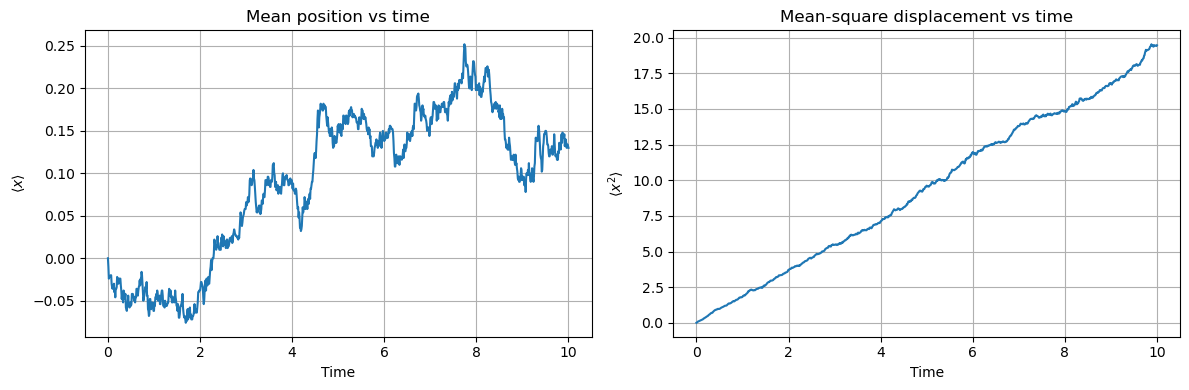

In [45]:
# Mean position over walkers
mean_x = X.mean(axis=0)

# Mean-square displacement over walkers
msd = (X**2).mean(axis=0)

plt.figure(figsize=(12,4))

# Mean position
plt.subplot(1, 2, 1)
plt.plot(t, mean_x)
plt.xlabel("Time")
plt.ylabel(r"$\langle x \rangle$")
plt.title("Mean position vs time")
plt.grid(True)

# Mean-square displacement
plt.subplot(1, 2, 2)
plt.plot(t, msd)
plt.xlabel("Time")
plt.ylabel(r"$\langle x^2 \rangle$")
plt.title("Mean-square displacement vs time")
plt.grid(True)

plt.tight_layout()
plt.show()

### 2.1 Mean and mean-square displacement

From the matrix `X`, where each row is a walker and each column is a time step, we can compute:

- the mean position at each time step,
- the mean-square displacement (MSD) at each time step.

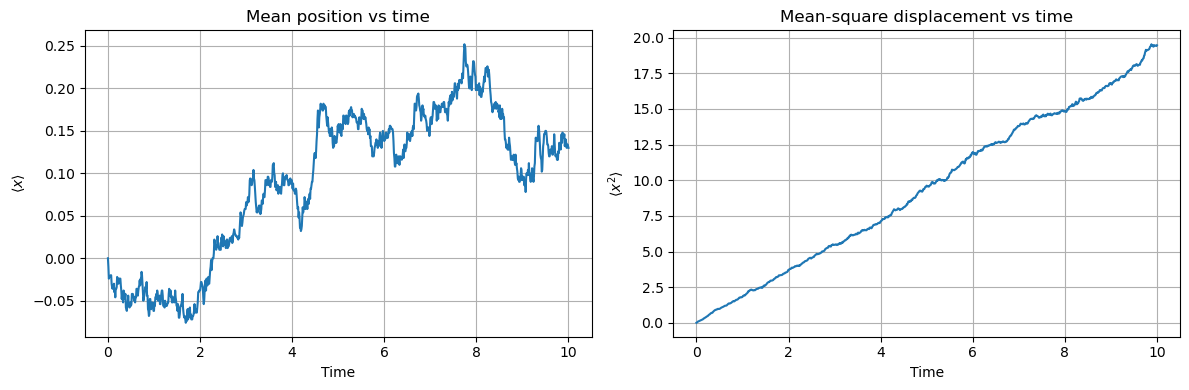

In [46]:
# Mean position over walkers
mean_x = X.mean(axis=0)

# Mean-square displacement over walkers
msd = (X**2).mean(axis=0)

plt.figure(figsize=(12,4))

# Mean position
plt.subplot(1, 2, 1)
plt.plot(t, mean_x)
plt.xlabel("Time")
plt.ylabel(r"$\langle x \rangle$")
plt.title("Mean position vs time")
plt.grid(True)

# Mean-square displacement
plt.subplot(1, 2, 2)
plt.plot(t, msd)
plt.xlabel("Time")
plt.ylabel(r"$\langle x^2 \rangle$")
plt.title("Mean-square displacement vs time")
plt.grid(True)

plt.tight_layout()
plt.show()


### 2.2 Comparing MSD with a straight line

For a discrete symmetric random walk with step size `a`, we expect:
  
$$
\langle x^2(n) \rangle \approx n \, a^2.
$$

Let us compare the measured MSD with this simple theoretical prediction.

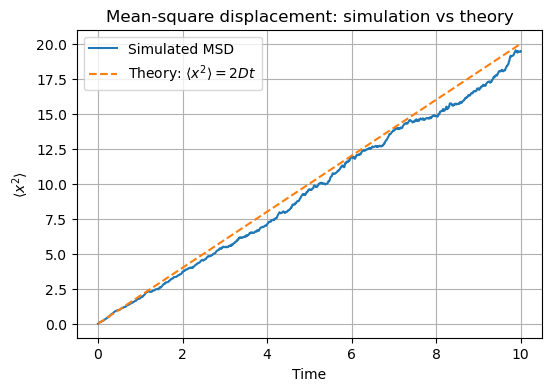

Estimated D from rates: D = 1.000 (in units of a^2 / time)


In [47]:
# Diffusion coefficient for this jump process:
# D = (a^2 / 2) * (rate_left + rate_right)
D = 0.5 * a**2 * (rate_left + rate_right)

theoretical_msd = 2 * D * t

plt.figure(figsize=(6,4))
plt.plot(t, msd, label="Simulated MSD")
plt.plot(t, theoretical_msd, '--', label=r"Theory: $\langle x^2 \rangle = 2Dt$")
plt.xlabel("Time")
plt.ylabel(r"$\langle x^2 \rangle$")
plt.title("Mean-square displacement: simulation vs theory")
plt.legend()
plt.grid(True)
plt.show()

print(f"Estimated D from rates: D = {D:.3f} (in units of a^2 / time)")

## 3. Histograms of positions and Gaussian shape

For a given step number `n`, the positions of all walkers form a distribution.
For large `n`, this distribution becomes approximately Gaussian (bell-shaped).

Let us look at the histograms of positions at a few different times.

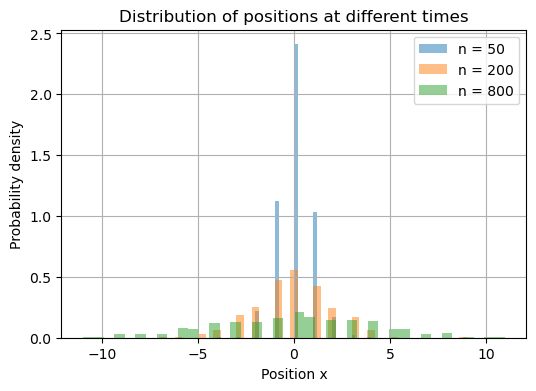

In [29]:
# Choose some time points (step numbers)
times = [50, 200, 800]  # you can change these

plt.figure(figsize=(6,4))

for t in times:
    plt.hist(X[:, t], bins=40, density=True, alpha=0.5, label=f"n = {t}")

plt.xlabel("Position x")
plt.ylabel("Probability density")
plt.title("Distribution of positions at different times")
plt.legend()
plt.grid(True)
plt.show()

## 4. From random walk to diffusion

The continuous limit of the random walk leads to the diffusion equation:

$$
\frac{\partial p}{\partial t} = D \frac{\partial^2 p}{\partial x^2},
$$

with diffusion coefficient \(D\) related to the discrete parameters of the walk.

If we choose a time step \(\Delta t\) and step size \(a\), then for a symmetric walk:
  
$$
D = \frac{a^2}{2 \Delta t}.
$$

The solution for an initially localised particle is a Gaussian:

$$
p(x,t) = \frac{1}{\sqrt{4 \pi D t}} \exp\left(-\frac{x^2}{4 D t}\right).
$$

We will not fit the Gaussian here in detail, but you can already see from the histograms that the shape is bell-like and broadens over time.

## 5. Biological distances and diffusion times

Finally, we use the diffusion law
  
$$
t \approx \frac{L^2}{2D}
$$

to estimate how long diffusion takes over different distances.

We will write a small helper function to compute this for typical biological values.

- `L` will be a distance in micrometers (µm),
- `D` will be a diffusion coefficient in µm²/s.


In [31]:
def diffusion_time(L, D):
    """
    Estimate diffusion time t ~ L^2 / (2D)
    
    Parameters
    ----------
    L : float
        Distance in micrometers (µm).
    D : float
        Diffusion coefficient in µm^2/s.
        
    Returns
    -------
    t : float
        Time in seconds.
    """
    return L**2 / (2.0 * D)

# Example 1: Protein in E. coli, L = 1 µm, D ≈ 7 µm^2/s
t_ecoli = diffusion_time(L=1.0, D=7.0)

# Example 2: Protein in cytoplasm over 10 µm (e.g. across a cell)
t_cell = diffusion_time(L=10.0, D=10.0)

# Example 3: Protein along a 10 cm axon (10 cm = 1e5 µm), D ≈ 10 µm^2/s
t_axon = diffusion_time(L=1e5, D=10.0)

print(f"E. coli (L = 1 µm, D = 7 µm^2/s): t ≈ {t_ecoli:.3f} s")
print(f"Cell-sized distance (L = 10 µm, D = 10 µm^2/s): t ≈ {t_cell:.3f} s")
print(f"Axon (L = 10 cm, D = 10 µm^2/s): t ≈ {t_axon:.2e} s (≈ {t_axon/3600/24:.1f} days)")

E. coli (L = 1 µm, D = 7 µm^2/s): t ≈ 0.071 s
Cell-sized distance (L = 10 µm, D = 10 µm^2/s): t ≈ 5.000 s
Axon (L = 10 cm, D = 10 µm^2/s): t ≈ 5.00e+08 s (≈ 5787.0 days)


## 6. Summary

In this notebook we:

- Simulated a simple one-dimensional random walk.
- Saw that the mean position stays around zero (no drift).
- Verified numerically that the mean-square displacement grows linearly with the number of steps.
- Observed that the distribution of positions becomes bell-shaped (Gaussian-like) at large times.
- Used the diffusion law \( t \approx L^2 / (2D) \) to estimate timescales over biological distances.

This connects the discrete picture of random steps to the continuous diffusion equation and to real biological problems such as protein motion in cells and transport in neurons.

## 7. Extension: a 3D random walk (diffusion in space)

So far we looked at diffusion in one dimension.  
Real molecules move in 3D.

Here we simulate a simple 3D random walk:

- At each time step the particle moves by a fixed distance `a`
- along one of the six directions: ±x, ±y, ±z (chosen at random).

This is the 3D analogue of the 1D random walk and is a simple model of a diffusing particle in space.

In [32]:
def random_walk_3d(N_steps, a=1.0):
    """
    Simulate a 3D random walk with steps of length a along ±x, ±y, ±z.
    
    Parameters
    ----------
    N_steps : int
        Number of steps.
    a : float
        Step length.
        
    Returns
    -------
    X : numpy array of shape (N_steps+1, 3)
        Positions (x, y, z) at each step.
    """
    X = np.zeros((N_steps + 1, 3))  # start at the origin
    
    for n in range(N_steps):
        # Choose a random direction among 6 possibilities:
        # 0: +x, 1: -x, 2: +y, 3: -y, 4: +z, 5: -z
        direction = np.random.randint(0, 6)
        
        if direction == 0:
            step = np.array([ a,  0,  0])
        elif direction == 1:
            step = np.array([-a,  0,  0])
        elif direction == 2:
            step = np.array([ 0,  a,  0])
        elif direction == 3:
            step = np.array([ 0, -a,  0])
        elif direction == 4:
            step = np.array([ 0,  0,  a])
        else:  # direction == 5
            step = np.array([ 0,  0, -a])
        
        X[n+1] = X[n] + step
    
    return X

# Quick test
X3d = random_walk_3d(10)
X3d.shape

(11, 3)

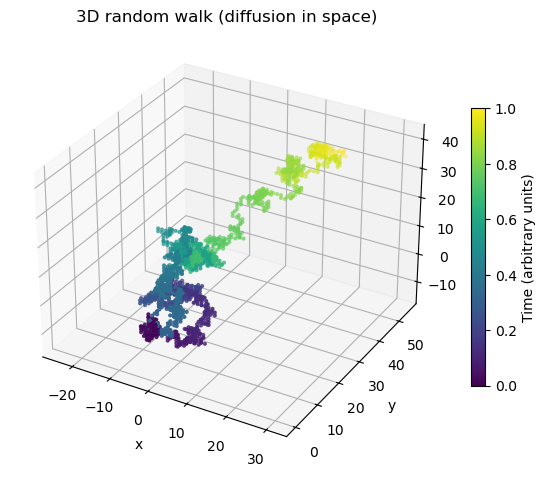

In [33]:
from mpl_toolkits.mplot3d import Axes3D  # needed in some matplotlib versions

# Number of steps for the 3D walk
N_steps_3d = 2000
a_3d = 1.0

X3d = random_walk_3d(N_steps_3d, a=a_3d)

x = X3d[:, 0]
y = X3d[:, 1]
z = X3d[:, 2]

# Colour along the trajectory (0 at start, 1 at end)
c = np.linspace(0, 1, N_steps_3d + 1)

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

# Scatter points with colour gradient
p = ax.scatter(x, y, z, c=c, cmap='viridis', s=4)

# Add a colourbar to show time progression
cb = fig.colorbar(p, ax=ax, shrink=0.6)
cb.set_label("Time (arbitrary units)")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("3D random walk (diffusion in space)")

# Make the aspect ratio roughly equal
max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
mid_x = 0.5*(x.max()+x.min())
mid_y = 0.5*(y.max()+y.min())
mid_z = 0.5*(z.max()+z.min())
ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

plt.show()

### 7.1 Interpreting the 3D random walk

This coloured 3D trajectory represents the path of a single diffusing particle:

- The point starts at the origin and performs small random jumps in 3D.
- The colour encodes time: dark points are early, bright points are later.
- Over time, the particle spreads away from its starting point in all directions.

Mathematically, each coordinate (x, y, z) behaves like an independent 1D random walk, 
so the mean-square displacement in 3D satisfies

$$
\langle r^2(t) \rangle = \langle x^2(t) + y^2(t) + z^2(t) \rangle = 6 D t,
$$

for a simple 3D diffusion process, where \(D\) is the diffusion coefficient.